In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

In [2]:
symbol_list = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
data = yf.download(
    symbol_list, 
    start='2014-01-01', 
    end='2015-01-01'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [6]:
print(data.head())
data.shape

                 AAPL       AMZN       GOOG       META       NFLX
Date                                                             
2014-01-02  17.364960  19.898500  27.724083  54.709999  51.831429
2014-01-03  16.983524  19.822001  27.521841  54.560001  51.871429
2014-01-06  17.076145  19.681499  27.828691  57.200001  51.367142
2014-01-07  16.954016  19.901501  28.365179  57.919998  48.500000
2014-01-08  17.061382  20.096001  28.424210  58.230000  48.712856


(252, 5)

In [7]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2) #finding the cointegration of every possible pair
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [8]:
scores, pvalues, pairs = find_cointegrated_pairs(data)

<Axes: >

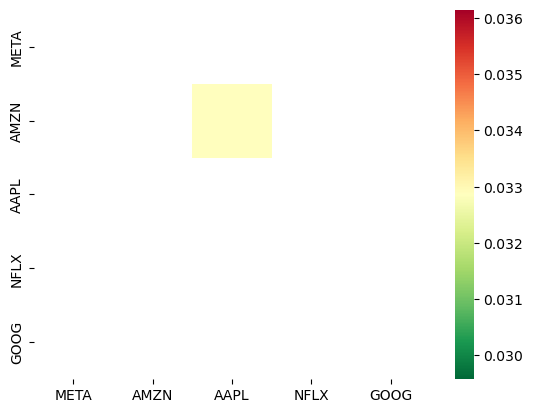

In [9]:
seaborn.heatmap(
    pvalues, 
    xticklabels=symbol_list, 
    yticklabels=symbol_list, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.05)
)

#### Thus, we see that Amazon and Apple are cointegrated.

In [15]:
S1 = data.AMZN
S2 = data.AAPL

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1.AMZN
b = results.params['AMZN']
spread = S2 - b * S1

#### One of the disadvantages of Linear regression to find the coefficient beta to get the I[0] series, because it is tough to understand which series would be the dependent one.  

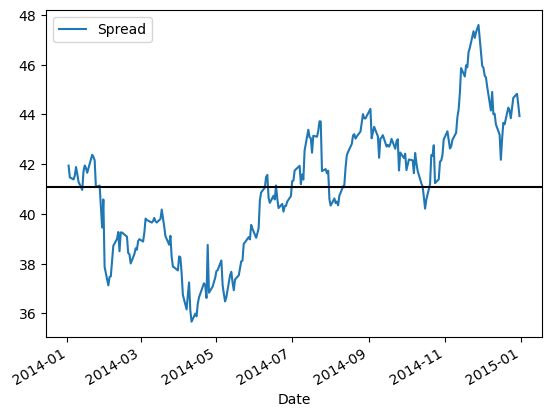

In [11]:
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

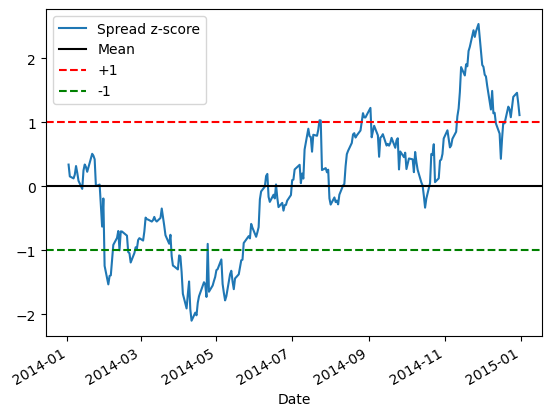

In [12]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

zscore(spread).plot() #Normalizing the spread of the pair
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [13]:
# Create a DataFrmae with the signal and position size in the pair
trades = pd.concat([zscore(spread), S2 - b * S1], axis=1)
trades.columns = ["signal", "position"]

# Add a long and short position at the z-score levels
trades["side"] = 0.0
trades.loc[trades.signal <= -1, "side"] = 1
trades.loc[trades.signal >= 1, "side"] = -1

In [16]:
trades.head()

,signal,position,side
Date,,,
2014-01-02,0.338627,41.943564,0.0
2014-01-03,0.153940,41.467636,0.0
2014-01-06,0.122537,41.386711,0.0
2014-01-07,0.180596,41.536326,0.0
2014-01-08,0.315489,41.883939,0.0


<Axes: xlabel='Date'>

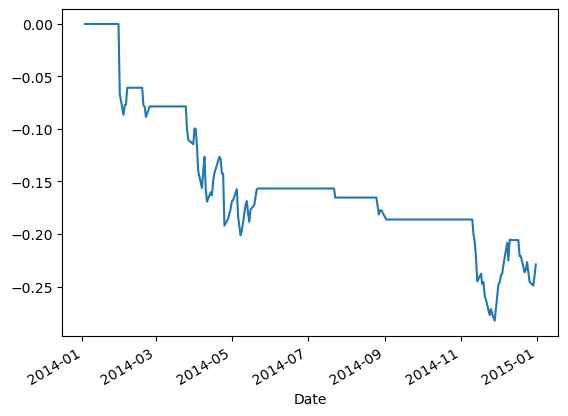

In [14]:
returns = trades.position.pct_change() * trades.side
returns.cumsum().plot()

In [20]:
returns.tail(20)

Date
2014-12-03    0.006848
2014-12-04    0.001584
2014-12-05    0.008255
2014-12-08    0.021133
2014-12-09   -0.016936
2014-12-10    0.020002
2014-12-11   -0.000451
2014-12-12   -0.000000
2014-12-15   -0.000000
2014-12-16   -0.000000
2014-12-17    0.000000
2014-12-18   -0.015252
2014-12-19   -0.000000
2014-12-22   -0.015374
2014-12-23    0.002376
2014-12-24    0.007251
2014-12-26   -0.018668
2014-12-29   -0.003677
2014-12-30    0.009354
2014-12-31    0.010743
dtype: float64

#### This pair consistently experiences financial losses, and this observation can be interpreted in several ways. Firstly, it's possible that there is no stable linear combination between the two stocks, leading to a false positive result. Alternatively, there might not be any genuine economic relationship that influences the behavior of both stocks. Another possibility is that there exists a linear combination and an economic relationship, but this relationship has been consistently breaking down during the time period under consideration.